# Assignment Requirements

Assignment Requirements:
Please set β = 0.8, and initial PageRank value = 1/N.
Show the top 10 vertices sorted by rank (if ranks are equal, sorted by ID in
ascending order), after 20 iterations.
Part1 Code(80%)
Please make sure that your file has the same name as PageRank.
(PageRank.java or PageRank.ipynb)
Part2 Report(20%)
Java :
1. Report.pdf (Explain how do you design your mapper and reducer)
2. Outputfile.txt (write your result of input.txt to this file)
Python:
1. Report.pdf or markdown in .ipynb file (Explain how do you design
your mapper and reducer.)
2. Outputfile.txt (write your result of input.txt to this file)
Please pack the above files into a zip file. Name it as
“MDA_HW2_studentID.zip”
Should notice:
- How to get ?
- (-5) Wrong output format
- (-5) Round-off error
- (-10) Cannot output the result of input-test.txt
N

## Configuation

In [3]:
import os
import sys
from pyspark.context import SparkContext,SparkConf
from pyspark.rdd import RDD
!pip install psutil
import psutil
#若沒有下面這段
#會有Exception: Java gateway process exited before sending its port number
#Config
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jre1.8.0_301'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


sc = SparkContext(conf=SparkConf().setAppName("PageRank").setMaster("local"))
print(f'sc:{sc}')
spark = SparkSession(sc)


You should consider upgrading via the 'c:\users\leoshr\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


sc:<SparkContext master=local appName=PageRank>


## Algo Design


### 實際測資

### Revised PageRank Algo Design

##### 1. input & output: 

- input
iterating_time:指定迭代次數
path: input檔案的路徑
saved_named: 儲存檔案的名稱

- output: RDD data and a stored file



#####  2. formatting
sc.textFile(path).map(lambda x:  (x.split("\t")[0], x.split("\t")[1])).cache()

1. read the txt file and turn the original format (transform ['1\t2']) into (['1','2'])
2. Setting the start node as format, and the end node as the element of a list, which sites at the place of j, eg,  [('0',('1','2','3','5')),('1',('2', '3', '1'))


##### 3. Building second  RDD for recording the rank value

Build a RDD having the same key as the previous RDD we converted, like [('1', page_value)]

1. num_a_spot: we extract the key as a sigle RDD called num_a_spot

2. num_b_spot: we extract the value as a sigle RDD called num_b_spot

3. discinct them and ->collect() -> sort them out  what exactly how many ending node this start node has.

4. get the result of (3) into the len() function to understand the total amount of node number we need to scatter the weights (RankValue/N)

5. links = pages.map(lambda x : (x[0], 1/N)) would return the RDD which looks like [(key, the average RankValue)]

##### 4. Scatter the PageRank 
1. iterating as the input 'iterating_time'
2. Scatter the value vias mapping
3. reduce: sum the value of the pair RDD by key. Therefore, we can get the total amount of updated RankValue with a unique key


##### 5-1 Revised check
1. depends on the formula: {rj =Σi→j  [β(ri/di)+ (1 − β)s/N]}, we should consider the effect of β and (1 − β)s/N,  β = 0.8, s = the difference between 1 and the total sum of current nodes' rank value

##### 5-2 Renormaliz to avoid spider  trap
(我們需要將所有pair RDD value sum起來#並將其命為S, 計算1-S/N)

2. we use mapping function to parallel computing the revised rank values

3. sorting 1. sorting by rankvalue descending , therefore, the rdds with higher ranking are being sorted frontier  

4. Use links_revised.mapValues(lambda x: (x+normalized_residual)) to make up the difference and avoid spider trap's effect

##### 6. Round off check
1. the assignment requires ound to the third non-zero digit after decimal point

2. After the observation, we set the round function to truncate at the sixth digit after the point can match the requirement


3. We only conduct this section of code in the last round to avoid the truncation error ('iterating_time-1' due to python start from 0, hence, 19th round should bbe the last round instead of the round 20)


##### 7. Auto_stored

1. we can auto store the result as our requirement. ps, the input parameter includes the stored output name we want.


#### Return the RDD result


In [3]:
##########this is the for loop function we defined


#別人的out-link 分給我們的value
#flatMap(f), f是在做根據 X[1][1]的長度，也就是自己outlink的數量進行分配給其他node
def scatter(x):
    temp = []
    len_outlink_num = len(x[1][0]) #看有多少outlink
    for y in x[1][0]:
        temp.append(tuple((y,x[1][1]/len_outlink_num)))
    return temp

def dynamic_round(x):
    temp = x
    i=0
    while (temp <1):
        i+=1
        temp = 10.0*temp 
        print(i)
    
    return round(x,int(i)+2)



def Re_PageRank(iterating_time,path,saved_named):
    ######  2. formatting
    rdd2 = sc.textFile(path).map(lambda x:  (x.split("\t")[0], x.split("\t")[1])).cache()
    pages = rdd2.groupByKey().map(lambda x : (x[0], list(x[1])))    
    
    ###### 3. Building second  RDD for recording the rank value   
    num_a_spot = rdd2.map(lambda x : x[0])
    num_b_spot = rdd2.map(lambda x : x[1])
    node_list = sorted(num_a_spot.union(num_b_spot).distinct().collect())
    N = len(node_list) #the total node number
    links = pages.map(lambda x : (x[0], 1/N))
    ##### 4. Scatter the PageRank 
    for time in range(iterating_time):
      
        #join two RDD as the format (key, ([outlink_nodes],rank_value))
        #scatter: map
        rank = pages.join(links).flatMap(scatter)
        #reduce: sum the value of the pair RDD by key
        links = rank.reduceByKey(lambda x,y: x+y)
        
        
        ###### 5-1. Revised check
        #revised: depends on the formula: {rj =Σi→j  β(ri/di)+ (1 − β) s/N}
        #Revised check preparation:
        links_revised = links.mapValues(lambda x: 0.8*x+ 0.2*(1/N))
        
        ####  5-2 Renormaliz to avoid spider  trap
        #我們需要將所有pair RDD value sum起來
        #並將其命為S, 計算1-S/N

        temp = links_revised.map(lambda x: x[1])
        s = sum(temp.collect())
        normalized_residual = (1-s)/N
     
        #sorting 1. sorting by rank decending
        #sortbyvalue desending , therefore, the rdds with higher ranking are sorted frontier  
        links = links_revised.mapValues(lambda x: (x+normalized_residual))
        print(f'i am not rounded! And it is {time} round')
       
        links_revised = links.sortBy(lambda a: -a[1])

        if time == iterating_time-1: 
        #擔心每次都截尾會造成大迭代次數時的誤差，因此最後一次迭代時再四捨五入到非零整數第三位
            #result = links_revised.mapValues(lambda x: round(x,6))
            result = links_revised.mapValues(lambda x: dynamic_round(x))
            print('i am rounded! And it is the final round')
## 7. Auto_stored 
   
    fp = open(saved_named, 'w')
    for element in result.collect():
        jj = str(element[0])+'    '+str(element[1])
        #print(jj)
        fp.write(jj+'\n')

    fp.close()   
    return result#.collect()
    
        


In [4]:
p_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\CH2_PageRank_Pyspark\\input.txt'
iterating_time = 20
saved_named = 'Outputfile.txt'

ans = Re_PageRank(iterating_time,p_path,saved_named).collect()
ans

i am not rounded! And it is 0 round
i am not rounded! And it is 1 round
i am not rounded! And it is 2 round
i am not rounded! And it is 3 round
i am not rounded! And it is 4 round
i am not rounded! And it is 5 round
i am not rounded! And it is 6 round
i am not rounded! And it is 7 round
i am not rounded! And it is 8 round
i am not rounded! And it is 9 round
i am not rounded! And it is 10 round
i am not rounded! And it is 11 round
i am not rounded! And it is 12 round
i am not rounded! And it is 13 round
i am not rounded! And it is 14 round
i am not rounded! And it is 15 round
i am not rounded! And it is 16 round
i am not rounded! And it is 17 round
i am not rounded! And it is 18 round
i am not rounded! And it is 19 round
i am rounded! And it is the final round


[('10861', 0.00063),
 ('4240', 0.00063),
 ('6899', 0.000526),
 ('9526', 0.000513),
 ('2118', 0.000497),
 ('3419', 0.000486),
 ('1311', 0.000481),
 ('3186', 0.000472),
 ('3541', 0.000464),
 ('367', 0.000463),
 ('7233', 0.000462),
 ('353', 0.00046),
 ('5734', 0.000442),
 ('10749', 0.00043),
 ('1558', 0.000421),
 ('6454', 0.000411),
 ('4366', 0.00041),
 ('251', 0.000406),
 ('2746', 0.000402),
 ('7847', 0.000401),
 ('2994', 0.000391),
 ('4709', 0.00039),
 ('5169', 0.000384),
 ('8123', 0.000381),
 ('5055', 0.00038),
 ('6426', 0.000379),
 ('5819', 0.000378),
 ('2653', 0.000376),
 ('10652', 0.000375),
 ('6514', 0.000373),
 ('10844', 0.000372),
 ('3185', 0.000372),
 ('4189', 0.000371),
 ('7829', 0.000367),
 ('6340', 0.000367),
 ('7880', 0.000363),
 ('687', 0.000357),
 ('2355', 0.000345),
 ('7922', 0.000343),
 ('4525', 0.00034),
 ('5825', 0.00034),
 ('2773', 0.000339),
 ('2571', 0.000339),
 ('6238', 0.000339),
 ('2110', 0.000338),
 ('8343', 0.000336),
 ('5985', 0.000336),
 ('2859', 0.000335),
 

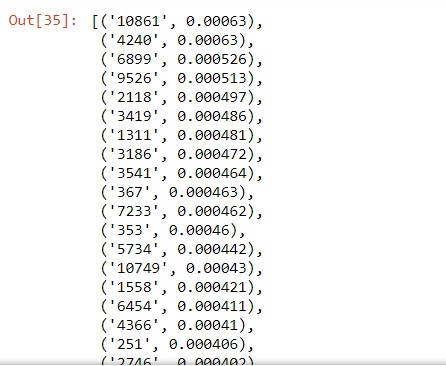

### input-test.txt Testing

1. only 10 run

In [ ]:
p_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\CH2_PageRank_Pyspark\\input-test.txt'
saved_named = 'input-test_result.txt'
iterating_time = 10

In [ ]:
def scatter(x):
    temp = []
    len_outlink_num = len(x[1][0]) #看有多少outlink
    for y in x[1][0]:
        temp.append(tuple((y,x[1][1]/len_outlink_num)))
    return temp

def dynamic_round(x):
    temp = x
    i=0
    while (temp <1):
        i+=1
        temp = 10.0*temp 
        print(i)
    
    return round(x,int(i)+2)



def Re_PageRank(iterating_time,path,saved_named):
    ######  2. formatting
    rdd2 = sc.textFile(path).map(lambda x:  (x.split("\t")[0], x.split("\t")[1])).cache()
    pages = rdd2.groupByKey().map(lambda x : (x[0], list(x[1])))    
    
    ###### 3. Building second  RDD for recording the rank value   
    num_a_spot = rdd2.map(lambda x : x[0])
    num_b_spot = rdd2.map(lambda x : x[1])
    node_list = sorted(num_a_spot.union(num_b_spot).distinct().collect())
    N = len(node_list) #the total node number
    links = pages.map(lambda x : (x[0], 1/N))
    ##### 4. Scatter the PageRank 
    for time in range(iterating_time):
      
        #join two RDD as the format (key, ([outlink_nodes],rank_value))
        #scatter: map
        rank = pages.join(links).flatMap(scatter)
        #reduce: sum the value of the pair RDD by key
        links = rank.reduceByKey(lambda x,y: x+y)
        
        
        ###### 5-1. Revised check
        #revised: depends on the formula: {rj =Σi→j  β(ri/di)+ (1 − β) s/N}
        #Revised check preparation:
        links_revised = links.mapValues(lambda x: 0.8*x+ 0.2*(1/N))
        
        ####  5-2 Renormaliz to avoid spider  trap
        #我們需要將所有pair RDD value sum起來
        #並將其命為S, 計算1-S/N

        temp = links_revised.map(lambda x: x[1])
        s = sum(temp.collect())
        normalized_residual = (1-s)/N
     
        #sorting 1. sorting by rank decending
        #sortbyvalue desending , therefore, the rdds with higher ranking are sorted frontier  
        links = links_revised.mapValues(lambda x: (x+normalized_residual))
        
        links_revised = links.sortBy(lambda a: -a[1])
        print(f'i am rounded! And it is {time} round')

        if time == iterating_time-1: 
        #擔心每次都截尾會造成大迭代次數時的誤差，因此最後一次迭代時再四捨五入到非零整數第三位
            #result = links_revised.mapValues(lambda x: round(x,6))
            result = links_revised.mapValues(lambda x: dynamic_round(x))
            print('i am rounded! And it is the final round')
## 7. Auto_stored 
   
    fp = open(saved_named, 'w')
    for element in result.collect():
        jj = str(element[0])+'    '+str(element[1])
        #print(jj)
        fp.write(jj+'\n')

    fp.close()   
    return result#.collect()

        


In [ ]:
ans = Re_PageRank(iterating_time,p_path,saved_named).collect()
ans